# Demo: Estimating Optical Flow using DAISY features with PyTorch

This demo shows how to extract DAISY features and how to use them to find dense matches between a pair of consecutive images in a video (also referred to as optical flow).

Please note that this is a just very simple example to show how the DAISY features may be used for a practical task. This approach consists of comparing the descriptor of each pixel on the first image with the descriptors of neighboring pixels on the second image to find the maximum local matching.

In [1]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from daisy_torch import DaisyTorch
from third_party.flowiz import flowiz

%matplotlib inline

In [2]:
def find_local_matches(desc1, desc2, kernel_size=9):
    # Computes the correlation between each pixel on desc1 with all neighbors
    # inside a window of size (kernel_size, kernel_size) on desc2. The match
    # vector if then computed by linking each pixel on desc1 with
    # the pixel with desc2 with the highest correlation.
    #
    # This approch requires a lot of memory to build the unfolded descriptor.
    # A better approach is to use the Correlation package from e.g.
    # https://github.com/NVIDIA/flownet2-pytorch/tree/master/networks/correlation_package
    desc2_unfolded = F.unfold(desc2, kernel_size, padding=kernel_size//2)
    desc2_unfolded = desc2_unfolded.reshape(
        1, desc2.shape[1], kernel_size*kernel_size, desc2.shape[2], desc2.shape[3])
    desc1 = desc1.unsqueeze(dim=2)
    correlation = torch.sum(desc1 * desc2_unfolded, dim=1)
    _, match_idx = torch.max(correlation, dim=1)
    hmatch = torch.fmod(match_idx, kernel_size) - kernel_size // 2
    vmatch = match_idx // kernel_size - kernel_size // 2
    matches = torch.cat((hmatch, vmatch), dim=0)
    return matches

In [3]:
# If you run out or memory, try increasing the two variables below.
# Running this example with daisy_step=2, image_resize_factor=1, and fp16=True
# requires a GPU with at least 8GB
daisy_step = 2
image_resize_factor = 1

daisy = DaisyTorch(
    step=daisy_step,
    radius=5,
    rings=3,
    histograms=4,
    orientations=8,
    normalization='daisy',
    sigmas=None,
    ring_radii=None,
    fp16=True,
    return_numpy=False)
imgs = [
    cv2.imread('mpi_sintel_images/frame_0001.png', 0),
    cv2.imread('mpi_sintel_images/frame_0002.png', 0)
]
imgs = [cv2.resize(im, (im.shape[1]//image_resize_factor, im.shape[0]//image_resize_factor)) for im in imgs]
print('Warm-up step, will be slow on GPU')
descs = daisy.extract_descriptor(imgs)
print('Subsequent runs will be faster (on GPU)')
descs = daisy.extract_descriptor(imgs)
print('Descriptor shape:', descs.shape)

Warm-up step, will be slow on GPU
total time: 66.9 ms
Subsequent runs will be faster (on GPU)
total time: 8.3 ms
Descriptor shape: torch.Size([2, 104, 213, 507])


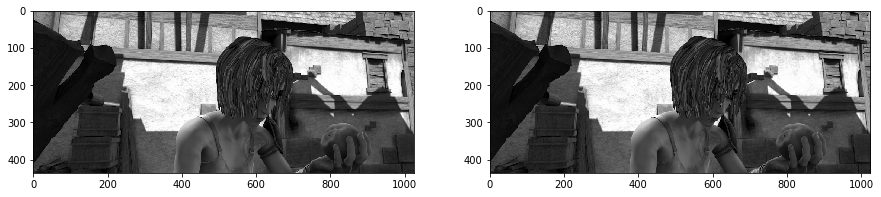

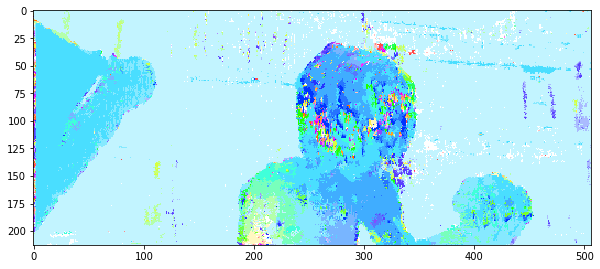

In [4]:
flow = find_local_matches(descs[0:1], descs[1:2], 7)

# Show input images
fig=plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(imgs[0], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(imgs[1], cmap='gray')
plt.show()

# Show optical flow
flow = flow.permute(1, 2, 0).detach().cpu().numpy()
flow_img = flowiz.convert_from_flow(flow)
fig=plt.figure(figsize=(10, 5))
plt.imshow(flow_img)
plt.show()